---
## Regularización

$$ \huge L = ||\hat{y}-y_i||^2 + \lambda g(w)$$

donde:

$\lambda > 0$ y $g(w)$ una funcion que penalizara ciertos valores de $w$

** Nota importante**: Normalmente estos modelos requieren normalización 


# Ridge regression 
**L2 regularization o Weight decay**

Creencia a priori de que los w's deberias ser chicos (prior belief)
- Restringe los valores altos de $w$ todos por igual ($0.5^2 + 0.5^2 < 1^2+0^2$)
- Se puede demostrar que es un estimador polarizado de los w's, pero posee menor varianza que simplemente minimizar la loss
- $g(w) = \|w\|^2$ 
- Es muy importante preprocesar: restar media y dividir por desvio por que $\lambda$ es el mismo para todos los $w$'s


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def get_lin_reg_pol(data, order=1, normalize=True, mean = 0, std = 1):
    data_rep = np.repeat(data.reshape(-1,1), order+1, axis=1)
    exps = [i for i in range(order+1)]
    data_all = np.power(data_rep, exps)
    if normalize:
        mean = data_all.mean(axis=0)[1:]
        std = data_all.std(axis=0)[1:]
        data_all[:, 1:] = data_all[:, 1:] - data_all.mean(axis=0)[1:]
        data_all[:, 1:] = data_all[:, 1:]/data_all.std(axis=0)[1:]
        return data_all, mean, std
    else:
        data_all[:, 1:] = data_all[:, 1:] - mean
        data_all[:, 1:] = data_all[:, 1:]/std
        return data_all

def get_ridge_weights(alturas, pesos, lamb = 0.1):
    ident = np.matrix(np.identity(alturas.shape[1]))
    X = np.matrix(alturas)
    y = np.matrix(pesos).T
    wRR = (lamb*ident + X.T*X)**-1*X.T*y
    return wRR

def get_MLE_MAP_weights(alturas_pol, pesos, order = 3, lamb = 0.1, N = 20):
    # Devuelve dos arrays con los pesos de MAP y MLE
    ident = np.matrix(np.identity(order+1))
    WMLs = []
    WRRs = []
    for i in range(int(np.floor(len(pesos)/N))):
        X = np.matrix(alturas_pol[i*N:(i+1)*N])
        y = np.matrix(pesos[i*N:(i+1)*N]).T
        wML = ((X.T.dot(X))**-1*X.T)*y
        WMLs = WMLs + [wML.tolist()]
        wRR = (lamb*ident + X.T*X)**-1*X.T*y
        WRRs = WRRs + [wRR.tolist()]
        #print(i, len(y))
    WMLs = np.array(WMLs).reshape(-1,order+1)
    WRRs = np.array(WRRs).reshape(-1,order+1)
    return WMLs, WRRs

def plt_lin_reg_gauss(alturas, pesos, WML, sigma, Xmin, Xmax, Ymin, Ymax, order, mean, std, points = 100, ax=None):
    X = np.linspace(Xmin, Xmax, points)
    Y = np.linspace(Ymin, Ymax, points)
    X, Y = np.meshgrid(X, Y)
    Xr = X.reshape(-1)
    Yr = Y.reshape(-1)
    Y_est = get_lin_reg_pol(Xr, order, normalize=False, mean=mean, std=std).dot(WML)
    Z = norm.pdf(Yr - Y_est, 0, sigma).reshape(points, points)
    Z_points = norm.pdf(pesos - get_lin_reg_pol(alturas, order, normalize=False, mean=mean, std=std).dot(WML),0 , sigma)
    if ax is None:
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
    ax.contour3D(X, Y, Z, 512)
    ax.scatter3D(alturas, pesos, Z_points, color='r', marker='o')
    ax.view_init(65,-120)
    plt.show()

def get_curves(alturas_pol, pesos, al_min, al_max, mean, std, order = 3, N=20, lamb = 1, ptos = 100):
    WMLs, WRRs = get_MLE_MAP_weights(alturas_pol, pesos, order = order, lamb = lamb, N = N)
    al = np.linspace(al_min, al_max,ptos)
    al_lin_pol = get_lin_reg_pol(al, order, normalize=False, mean=mean, std=std)
    curv_MLE = np.zeros([len(WMLs), ptos])
    curv_MAP = np.zeros([len(WRRs), ptos])
    for i, w in enumerate(WMLs):
        curv_MLE[i] = al_lin_pol.dot(w)
    for i, w in enumerate(WRRs):
        curv_MAP[i] = al_lin_pol.dot(w)
    return curv_MLE, curv_MAP


# Datos
Suponemos que tienen distribución Gaussiana por lo que el mejor estimador de todos (los lineales y los no lineales) es el lineal por ser los pesos y alturas conjuntamente Gaussianas

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/LCaravaggio/AnalisisPredictivo/master/05_Otros_Regresi%C3%B3n/data/alturas-pesos-mils-train.csv')

In [4]:
data = df[['Altura', 'Peso']].values

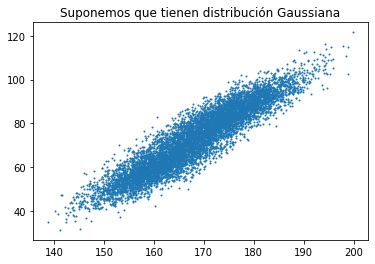

In [5]:
plt.scatter(data[:,0], data[:,1], s=1)
plt.title('Suponemos que tienen distribución Gaussiana')
plt.show()

In [6]:
len(df)

8000

# Regresión Lineal
Con todo el dataset de train (8000 observaciones)

$\large \hat{y} = w_o + w_1 x$

In [7]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(data[:,0].reshape(-1,1), data[:,1])
w_LR = np.array([clf.intercept_, clf.coef_[0]]).reshape(2,1)
print(w_LR)

[[-158.41934476]
 [   1.37539177]]


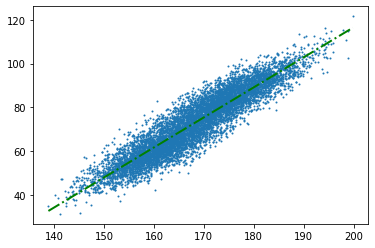

In [8]:
# puntos para recta
ptos = 100
alturas_lineal = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
alturas_lineal_bias = get_lin_reg_pol(alturas_lineal, order=1, normalize=False)
pesos_LR = alturas_lineal_bias.dot(w_LR)
plt.scatter(data[:,0], data[:,1], s=1)
plt.plot(alturas_lineal, pesos_LR, 'g', ls='-.', lw=2)
plt.show()

# Con solo 20 observaciones
Calculo todas

In [9]:
order = 1
N=20
lamb = 1
# devuelve los datos polinomiales normalizados. En este caso orden 1
alturas_pol, mean, std = get_lin_reg_pol(data[:,0], order, normalize=True)
# Calcula todas las regresiones lineales de a 20 puntos. Las de Ridge y las de MLE
WMLs, WRRs = get_MLE_MAP_weights(alturas_pol, data[:,1], order = order, lamb = lamb, N = N)
print(f'{len(WMLs)} regresiones calculadas para MLE y otras {len(WRRs)} para RR')

400 regresiones calculadas para MLE y otras 400 para RR


In [10]:
np.argmin(WMLs)

101

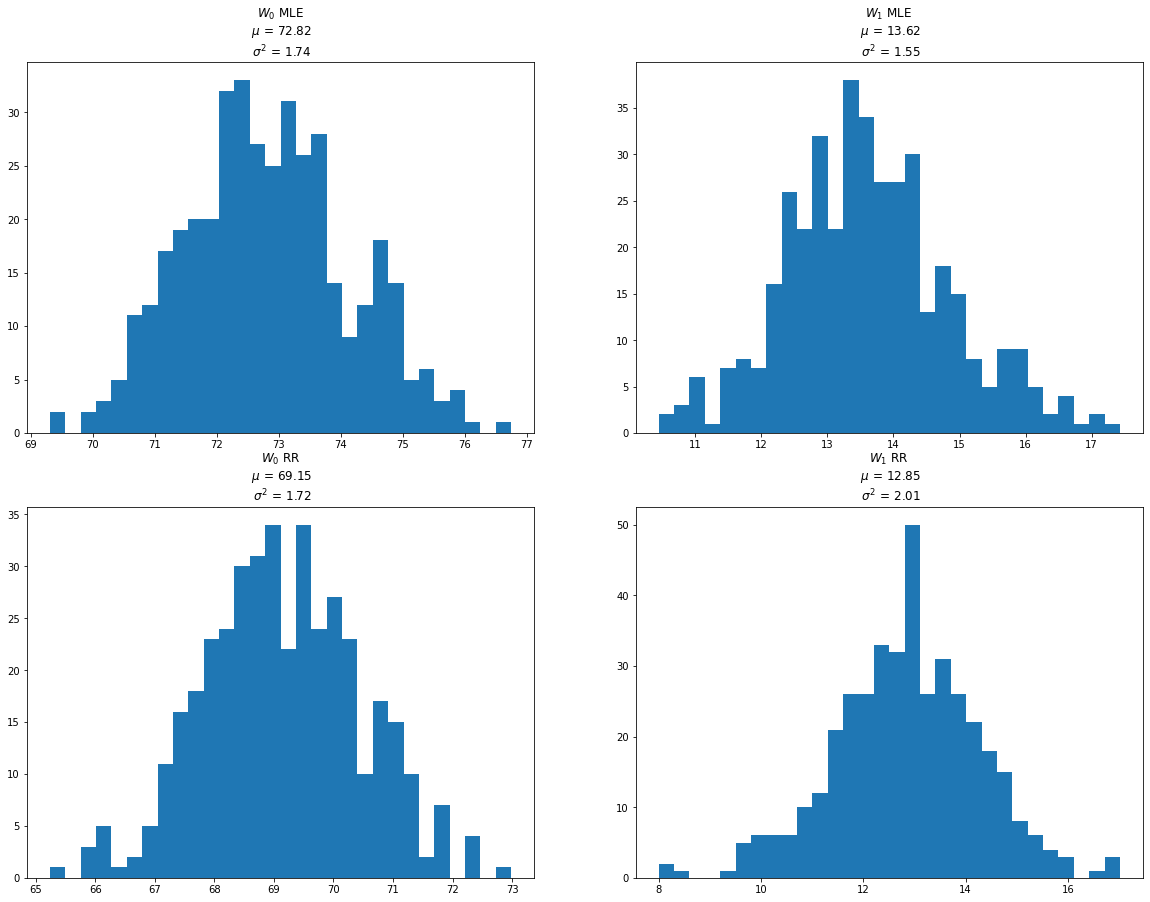

In [11]:
f, ax = plt.subplots(2, 2, figsize=(20,15))
_=ax[0, 0].hist(WMLs[:,0], 30)
_=ax[0, 1].hist(WMLs[:,1], 30)
_=ax[1, 0].hist(WRRs[:,0], 30)
_=ax[1, 1].hist(WRRs[:,1], 30)

ax[0, 0].set_title(f'$W_0$ MLE \n $\mu$ = {np.mean(WMLs[:,0]):.2f} \n $\sigma^2$ = {np.var(WMLs[:,0]):.2f}')
ax[0, 1].set_title(f'$W_1$ MLE \n $\mu$ = {np.mean(WMLs[:,1]):.2f} \n $\sigma^2$ = {np.var(WMLs[:,1]):.2f}')
ax[1, 0].set_title(f'$W_0$ RR \n $\mu$ = {np.mean(WRRs[:,0]):.2f} \n $\sigma^2$ = {np.var(WRRs[:,0]):.2f}')
_ = ax[1, 1].set_title(f'$W_1$ RR \n $\mu$ = {np.mean(WRRs[:,1]):.2f} \n $\sigma^2$ = {np.var(WRRs[:,1]):.2f}')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


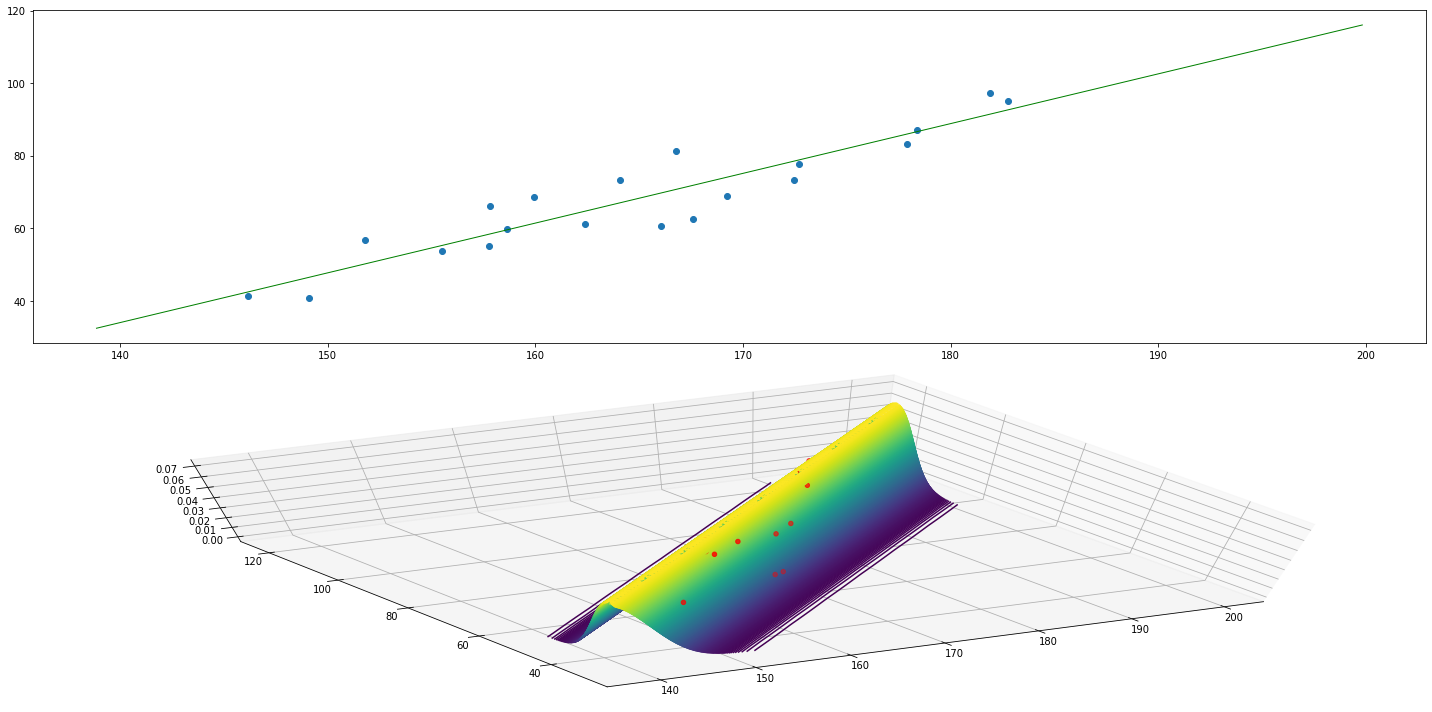

In [12]:
#%matplotlib qt
# Para cada i hay una solucion diferente ya que se usaron distintas observaciones
i = 0
al = np.linspace(data[:,0].min(),data[:,0].max(), 100)
alturas = data[i*N:(i+1)*N, 0]
pesos = data[i*N:(i+1)*N, 1]
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2, 1, 1)
ax1 = fig.add_subplot(2, 1, 2, projection='3d')
ax0.scatter(alturas, pesos)
sigma = (get_lin_reg_pol(alturas, order, normalize=False, mean=mean, std=std).dot(WMLs[i]) - pesos).std()
pe_MLE = get_lin_reg_pol(al, order, normalize=False, mean=mean, std=std).dot(WMLs[i])
ax0.plot(al, pe_MLE, 'g', lw=1)
plt.tight_layout()
plt_lin_reg_gauss(alturas, pesos, WMLs[i], sigma, data[:,0].min(),data[:,0].max(), data[:,1].min(),data[:,1].max(),order, mean, std, points = 100, ax=ax1)
plt.show()

# MLE (Maximum Likelihood Estimation)
$Y \sim N(Xw, \sigma^2I)$

$x_i$ e $y_i$ tienen dimensión $d$ mientras que N es el tamaño del dataset

$p(y_i|x_i;w) = N(x_i^Tw, \sigma^2)$

\begin{equation}
\large  p(y|x; w) = L(w; y_i, x_i) = \prod_{i}^N p(y_i|x_i;w) = \frac{1}{\sqrt{(2\pi)^N\sigma^2}} \prod_{i}^N  e^{-\frac{{(y_i-x_i^Tw)^2}}{2\sigma^2}}
\end{equation}

\begin{equation}
\large
log(L(w; y_i, x_i)) = -\frac{1}{2\sigma^2}\sum_i^N{(y_i-x_i^Tw)^2} + K
\end{equation}

\begin{equation}
\large
J(w) = \frac{1}{N}\sum_i^N{(y_i-x_i^Tw)^2}
\end{equation}

$w_{ML} = (X^TX)^{-1}X^T y$  
$E[w_{ML}] = w$ -> Estimador no polarizado. Los $w_{ML}$ son V.A y hacer least squares es muestrearlas  
$\Sigma[w_{ML}] = \sigma^2 (X^TX)^{-1}$ -> Si esta varianza es grande, no es un buen estimador  

Se puede demostrar que si hay correlación alta entre las columnas de X, la varianza de los w's puede ser muy alta
- Estimador no polarizado
- De alta varianza en muchas circunstancias
- $w_{LS} = w_{ML}$ (Maximun Likelihood es igual a least squares)

# Regresión Polinomial
De a N ejemplos

In [13]:
order = 3
N=20
lamb = 1
alturas_pol, mean, std = get_lin_reg_pol(data[:,0], order, normalize=True)
WMLs, WRRs = get_MLE_MAP_weights(alturas_pol, data[:,1], order = order, lamb = lamb, N = N)

$\large \hat{y} = w_o + w_1 x + w_2 x^2 + ... + w_2 x^N$

$\large \hat{y} = w_o + w_1 x + w_2 x_1 + ... + w_2 x_N$

In [14]:
# No son en este ejemplo exactamente al cuadrado por que cada X_i esta normalizada
alturas_pol[:10]

array([[ 1.        , -0.58111413, -0.59919284, -0.61492352],
       [ 1.        ,  1.40354187,  1.42883852,  1.45108504],
       [ 1.        ,  0.44214463,  0.41773429,  0.39184215],
       [ 1.        , -1.05463966, -1.04911428, -1.0406829 ],
       [ 1.        , -1.6600279 , -1.60527328, -1.54956959],
       [ 1.        , -0.96561197, -0.96552289, -0.96251963],
       [ 1.        ,  0.46717413,  0.44337425,  0.41799906],
       [ 1.        ,  0.11309831,  0.08406098,  0.0548634 ],
       [ 1.        , -1.28468719, -1.26297334, -1.23867548],
       [ 1.        ,  0.99655817,  0.99423097,  0.98887532]])

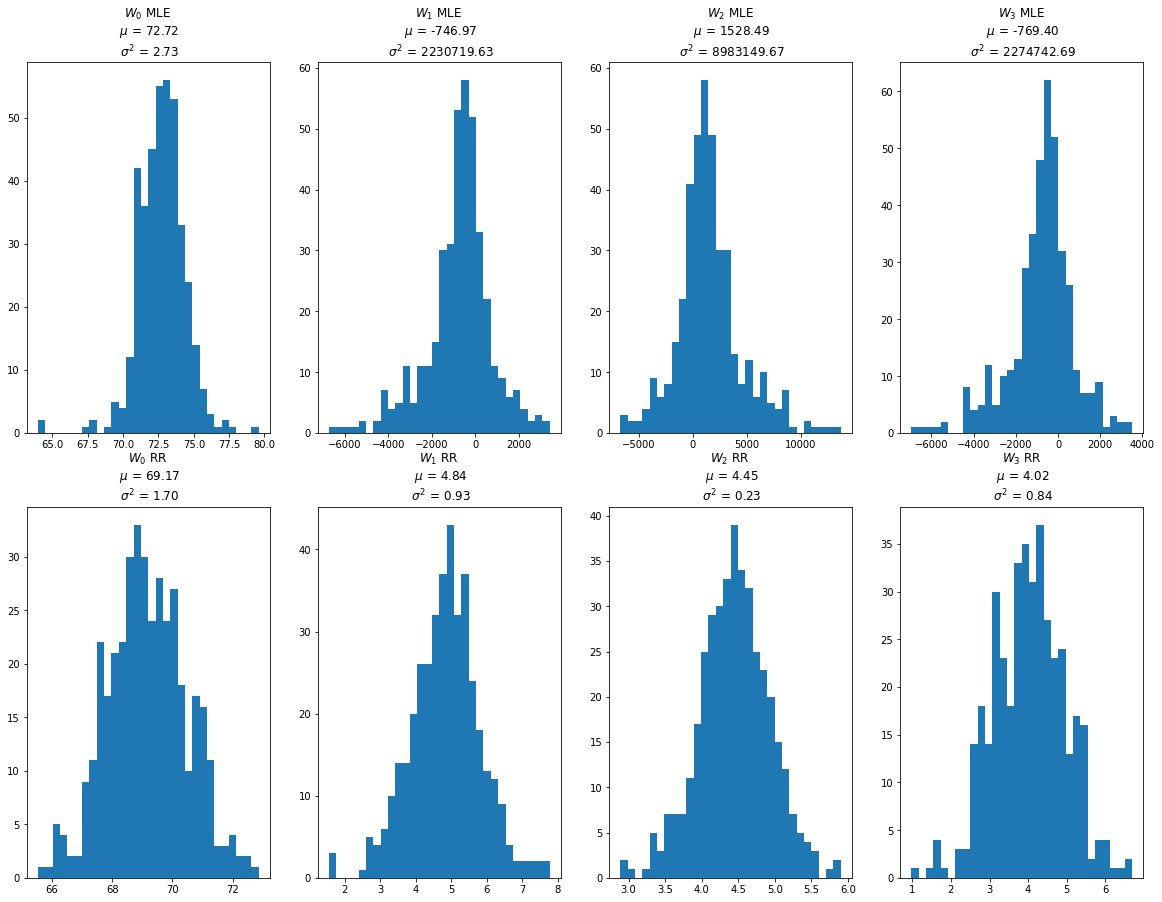

In [15]:
f, ax = plt.subplots(2, 4, figsize=(20,15))
_=ax[0, 0].hist(WMLs[:,0], 30)
_=ax[0, 1].hist(WMLs[:,1], 30)
_=ax[0, 2].hist(WMLs[:,2], 30)
_=ax[0, 3].hist(WMLs[:,3], 30)
_=ax[1, 0].hist(WRRs[:,0], 30)
_=ax[1, 1].hist(WRRs[:,1], 30)
_=ax[1, 2].hist(WRRs[:,2], 30)
_=ax[1, 3].hist(WRRs[:,3], 30)

ax[0, 0].set_title(f'$W_0$ MLE \n $\mu$ = {np.mean(WMLs[:,0]):.2f} \n $\sigma^2$ = {np.var(WMLs[:,0]):.2f}')
ax[0, 1].set_title(f'$W_1$ MLE \n $\mu$ = {np.mean(WMLs[:,1]):.2f} \n $\sigma^2$ = {np.var(WMLs[:,1]):.2f}')
ax[0, 2].set_title(f'$W_2$ MLE \n $\mu$ = {np.mean(WMLs[:,2]):.2f} \n $\sigma^2$ = {np.var(WMLs[:,2]):.2f}')
ax[0, 3].set_title(f'$W_3$ MLE \n $\mu$ = {np.mean(WMLs[:,3]):.2f} \n $\sigma^2$ = {np.var(WMLs[:,3]):.2f}')
ax[1, 0].set_title(f'$W_0$ RR \n $\mu$ = {np.mean(WRRs[:,0]):.2f} \n $\sigma^2$ = {np.var(WRRs[:,0]):.2f}')
ax[1, 1].set_title(f'$W_1$ RR \n $\mu$ = {np.mean(WRRs[:,1]):.2f} \n $\sigma^2$ = {np.var(WRRs[:,1]):.2f}')
ax[1, 2].set_title(f'$W_2$ RR \n $\mu$ = {np.mean(WRRs[:,2]):.2f} \n $\sigma^2$ = {np.var(WRRs[:,2]):.2f}')
_ = ax[1, 3].set_title(f'$W_3$ RR \n $\mu$ = {np.mean(WRRs[:,3]):.2f} \n $\sigma^2$ = {np.var(WRRs[:,3]):.2f}')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


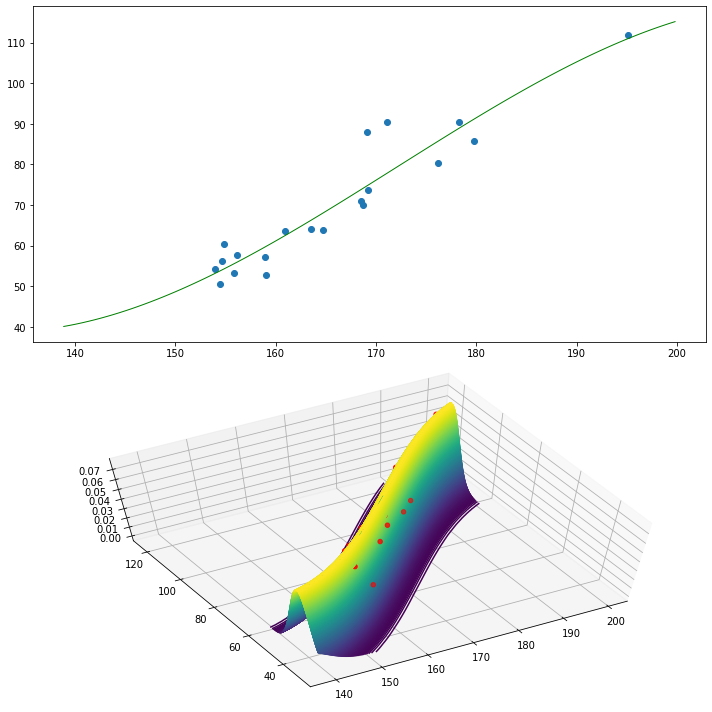

In [16]:
#%matplotlib qt
# Cambiar i y ver como va cambiando
i = 2
al = np.linspace(data[:,0].min(),data[:,0].max(), 100)
alturas = data[i*N:(i+1)*N, 0]
pesos = data[i*N:(i+1)*N, 1]
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(2, 1, 1)
ax1 = fig.add_subplot(2, 1, 2, projection='3d')
ax0.scatter(alturas, pesos)
sigma = (get_lin_reg_pol(alturas, order, normalize=False, mean=mean, std=std).dot(WMLs[i]) - pesos).std()
pe_MLE = get_lin_reg_pol(al, order, normalize=False, mean=mean, std=std).dot(WMLs[i])
ax0.plot(al, pe_MLE, 'g', lw=1)
plt.tight_layout()
plt_lin_reg_gauss(alturas, pesos, WMLs[i], sigma, data[:,0].min(),data[:,0].max(), data[:,1].min(),data[:,1].max(),order, mean, std, points = 100, ax=ax1)
plt.show()

# Regresión polinomial vs Ridge polinomial (L2)

### Regresión Ridge (MAP)

$Y \sim N(Xw, \sigma^2I)$

$w \sim N(0, \frac{\lambda^{-1} I_d}{2})$

$x_i$ e $y_i$ tienen dimensión $d$ mientras que N es el tamaño del dataset

\begin{equation}
\large  p(w|x,y) = \frac{p(y|x, w)p(w)}{p(y|x)}  = \frac{N(Xw, \sigma^2I) N(0, \frac{\lambda^{-1} I_d}{2})}{K_1}
\end{equation}

\begin{equation}
\large
p(w) = \frac{1}{\sqrt{(2\pi)^d|\Sigma_w|}}e^{-\frac{{w^T\Sigma_w^{-1} w}}{2}} = K_0e^{-{\lambda w^Tw}}
\end{equation}

\begin{equation}
\large
p(y_i|x_i;w) = \frac{1}{\sqrt{(2\pi)^N\sigma^2}} \prod_{i}^N  e^{-\frac{{(y_i-x_i^Tw)^2}}{2\sigma^2}}
\end{equation}

\begin{equation}
\large
 log(p(w|x,y))  = -\frac{1}{2\sigma^2}\sum_i^N{(y_i-x_i^Tw)^2} - \lambda \sum_{i}^d{w_i}^2 + K
\end{equation}

\begin{equation}
\large
J(w) = \frac{1}{N}\sum_i^N{(y_i-x_i^Tw)^2} + \lambda \sum_{i}^d{w_i}^2
\end{equation}

#### Regresión de Ridge  (MAP (Maximo a posteriori))  
$Y \sim N(Xw, \sigma^2I)$ ahora los w's tienen una distribución Gaussiana  
$w \sim N(0, \lambda^{-1}\sigma^2 I)$  distribución normal con media cero y varianza dependiendo de $\lambda$  
$w_{RR} = (\lambda I + X^TX)^{-1}X^T y$  (Se puede demostrar que son menores a los $w_{ml}$)   
$E[w_{RR}] = (\lambda I + X^TX)^{-1}X^T X w$  (w es la "ground truth")  
$\Sigma[w_{RR}] = \sigma^2 Z(X^TX)^{-1}Z^T$  (Es como un Z cuadrado)  
$Z = (I + \lambda (X^TX)^{-1})^{-1}$

- Estimador polarizado
- Menor varianza
- $w_{RR} = w_{MAP}$

# Para distintas observaciones (de a 20) graficar lo estimado por MLE y RR

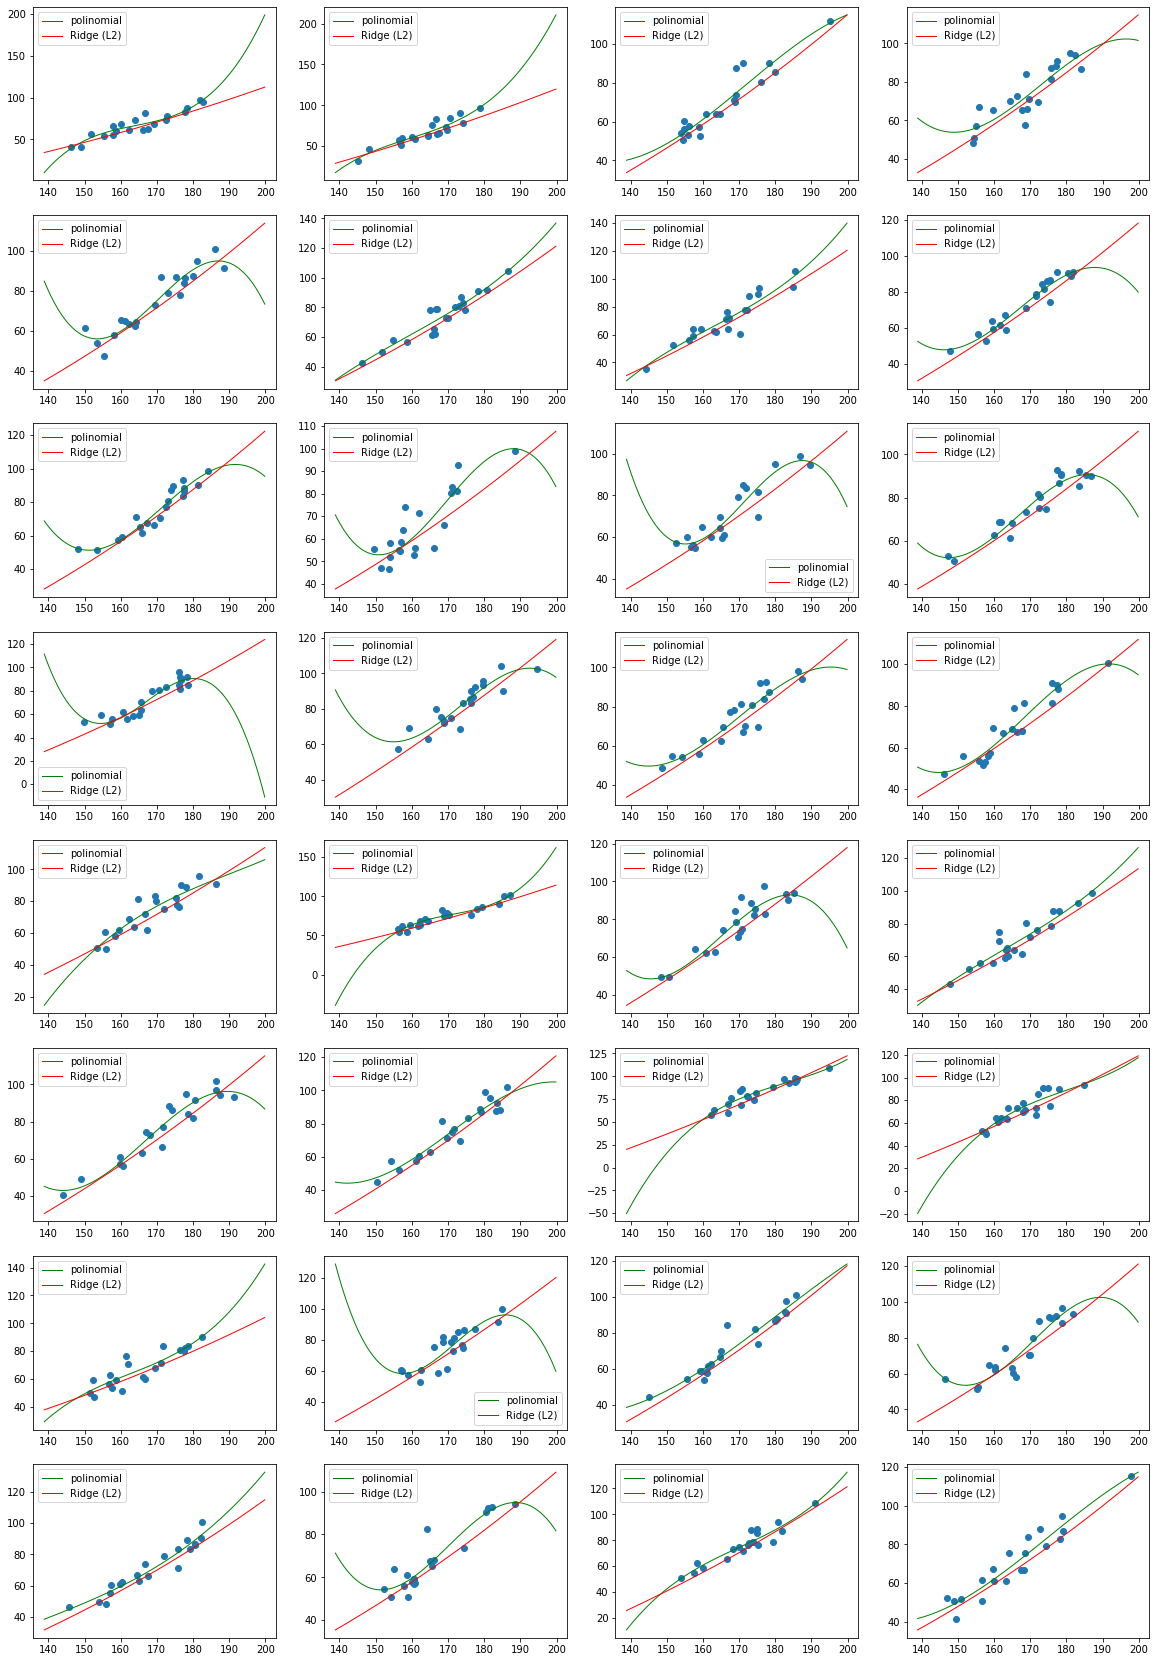

In [17]:
ptos = 100
f, ax = plt.subplots(8,4, figsize=(20,30))
ax = ax.reshape(-1)
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
al_pol = get_lin_reg_pol(al, order, normalize=False, mean=mean, std=std)
for i, w in enumerate(WMLs[:len(ax)]):
    ax[i].scatter(data[i*N:(i+1)*N, 0], data[i*N:(i+1)*N, 1])
    pe_MLE = al_pol.dot(w)
    pe_MAP = al_pol.dot(WRRs[i])
    ax[i].plot(al, pe_MLE, 'g', lw=1, label='polinomial')
    ax[i].plot(al, pe_MAP, 'r', lw=1, label='Ridge (L2)')
    ax[i].legend()
plt.show()

# Se realizan los promedios de los pesos de todas las estimaciones

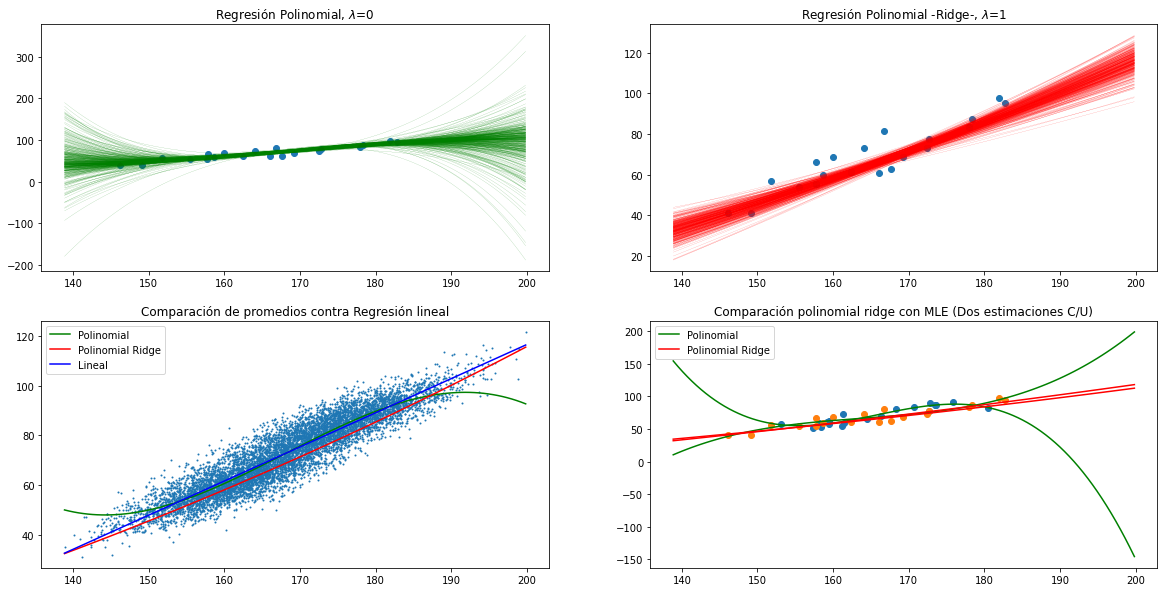

In [18]:
ptos = 100
f, ax = plt.subplots(2,2, figsize=(20,10))
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
al_pol = get_lin_reg_pol(al, order, normalize=False, mean=mean, std=std)
alturas_lineal_bias = get_lin_reg_pol(alturas_lineal, order=1, normalize=False)
ax[0,0].scatter(data[:N,0], data[:N,1])
ax[1,0].scatter(data[:,0], data[:,1], s=1)
ax[0,1].scatter(data[:N,0], data[:N,1])
K1 = 40
K2=0
ax[1,1].scatter(data[K1*N:(K1+1)*N, 0], data[K1*N:(K1+1)*N, 1])
ax[1,1].scatter(data[K2*N:(K2+1)*N, 0], data[K2*N:(K2+1)*N, 1])
ax[0,0].set_title("Regresión Polinomial, $\lambda$=0")
ax[0,1].set_title("Regresión Polinomial -Ridge-, $\lambda$=" + str(lamb))
pe_MLE = al_pol.dot(WMLs.mean(axis=0))
pe_MAP = al_pol.dot(WRRs.mean(axis=0))
pe_LR = alturas_lineal_bias.dot(w_LR)
ax[1,0].plot(al, pe_MLE, 'g', label='Polinomial')
ax[1,0].plot(al, pe_MAP, 'r', label='Polinomial Ridge')
ax[1,0].plot(al, pe_LR, 'b', label='Lineal')
ax[1,0].legend()
ax[1,0].set_title("Comparación de promedios contra Regresión lineal")

ax[1,1].plot(al, al_pol.dot(WMLs[K1]), 'g', label='Polinomial')
ax[1,1].plot(al, al_pol.dot(WMLs[K2]), 'g')
ax[1,1].plot(al, al_pol.dot(WRRs[K1]), 'r', label='Polinomial Ridge')
ax[1,1].plot(al, al_pol.dot(WRRs[K2]), 'r')
ax[1,1].set_title("Comparación polinomial ridge con MLE (Dos estimaciones C/U)")
ax[1,1].legend()

curv_MLE = np.zeros([len(WMLs), ptos])
curv_MAP = np.zeros([len(WRRs), ptos])
for i, w in enumerate(WMLs):
    curv_MLE[i] = al_pol.dot(w)

for i, w in enumerate(WRRs):
    curv_MAP[i] = al_pol.dot(w)
    
ax[0,0].plot(al, curv_MLE.T, 'g', lw=0.1)
ax[0,1].plot(al, curv_MAP.T, 'r', lw=0.1)


plt.show()

Se puede ver en el 3er grafico de arriba como la roja (Ridge) tiene mayor bias, comparada con la verde (MLE). La azul es la "ground truth"

# Media de polinomial y ridge comparada con lineal

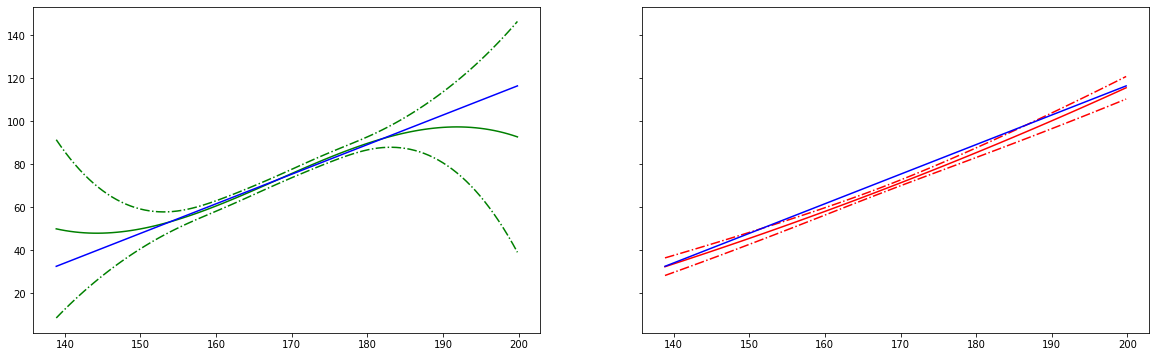

In [19]:
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
f, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(20,6))
ax[0].plot(al, curv_MLE.mean(axis=0), 'g')
ax[0].plot(al, curv_MLE.mean(axis=0) + curv_MLE.std(axis=0), 'g', ls='-.')
ax[0].plot(al, curv_MLE.mean(axis=0) - curv_MLE.std(axis=0), 'g', ls='-.')
ax[0].plot(al, pe_LR, 'b', label='Lineal')
ax[1].plot(al, curv_MAP.mean(axis=0), 'r')
ax[1].plot(al, curv_MAP.mean(axis=0) + curv_MAP.std(axis=0), 'r', ls='-.')
ax[1].plot(al, curv_MAP.mean(axis=0) - curv_MAP.std(axis=0), 'r', ls='-.')
ax[1].plot(al, pe_LR, 'b', label='Lineal')
plt.show()

Se puede ver en los gráficos superiores el bias de la RR

# Variamos Lambda

En los gráficos que siguen se puede ver como **lambdas muy bajos** dan lugar a un error debido a **alta varianza** y **lambdas muy altos** da lugar a error por **alto bias**

In [20]:
order = 3
alturas_pol, mean, std = get_lin_reg_pol(data[:,0], order, normalize=True)

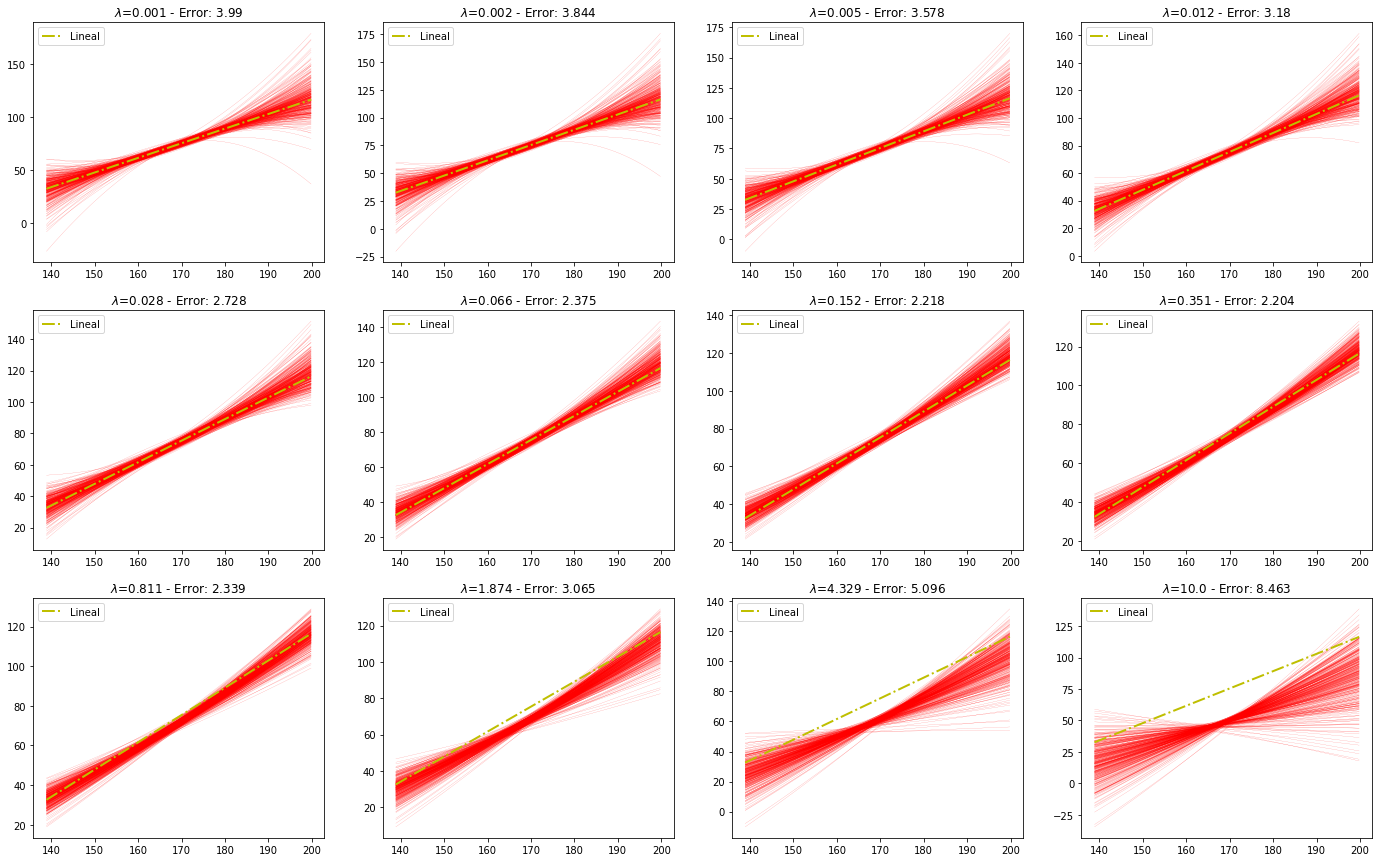

In [21]:
#%matplotlib inline
cols = 3
rows = 4
lambdas = np.logspace(-3, 1, cols*rows)
f, ax = plt.subplots(cols,rows, figsize=(24,15))
ax = ax.reshape(-1)
al = np.linspace(data[:,0].min(),data[:,0].max(), ptos)
errors = []
for i,lamb in enumerate(lambdas):    
    curv_MLE, curv_MAP = get_curves(alturas_pol, data[:,1],data[:,0].min(), data[:,0].max(), mean, std,order = 3, N=20, lamb = lamb)
    error = (curv_MAP.T-pe_LR).std(axis=0).mean()
    errors.append(error)
    ax[i].set_title("$\lambda$=" + str(np.round(lamb*1000)/1000) +" - Error: " + str(str(np.round(error*1000)/1000)))
    ax[i].plot(al, curv_MAP.T, 'r', lw=0.1)
    ax[i].plot(al, pe_LR, 'y', label='Lineal', lw=2, ls='-.')
    ax[i].legend()
plt.show()

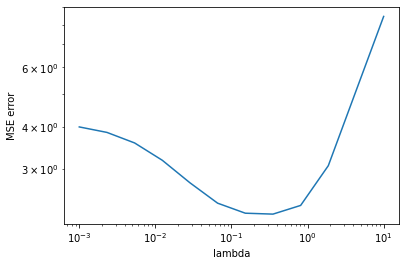

In [22]:
plt.loglog(lambdas, errors)
plt.xlabel('lambda')
plt.ylabel('MSE error')
plt.show()

**Como ver esto en la practica para el caso de la regresión lineal:**

$\large E[(y_0 - x_0^T\hat w)^2|X, x_0] = \sigma^2 + x_0^T(w - E[\hat w])(w - E[\hat w])^Tx_0 + x_0^T \Sigma [\hat w] x_0$

donde:  
- $X$: muestras de training set
- $x_0$: muestra de test set
- $y_0$: salida de test set
- $\hat w$: $w$'s estimadas con $X$
- $w$: ground truth
- $\sigma ^2$: ruido del modelo
- segundo termino: bias elevado al cuadrado. Tiende a cero para least squares. Distinto de cero para Ridge (Bias)
- tercer termino: Varianza. Suele ser menor para el caso de Ridge

**de que dependen nuestros resultados**
- de los datos
- del lambda